In [5]:
using Revise, ReachabilityAnalysis, BenchmarkTools

In [6]:
include("/home/mforets/.julia/dev/ReachabilityAnalysis/test/models/hybrid/embrake.jl")

embrake_pv_2 (generic function with 1 method)

# Flowpipe no pv

In [132]:
prob = embrake_no_pv(ζ=1e-7);

In [133]:
@time sol = solve(prob, alg=GLGM06(δ=1e-8), max_jumps=1000, force_static=true);

 26.320249 seconds (73.05 M allocations: 12.163 GiB, 13.19% gc time)


In [ ]:
@time sol = solve(prob, alg=GLGM06(δ=1e-8), max_jumps=1000, force_static=false);

## Requirements

1) Variable $x(t)$ is such that $\Vert x(t) - x_0 \Vert \leq \varepsilon$ for all $t \geq t_1$. We take $t_1 = 23ms$ and $x_0 = 0.05$.

In [82]:
const x0 = 0.05
const ε = 2e-3

0.002

2) The speed does is not bigger than a certain threshold  value once the disc makes contact: $\vert v(t) \vert \leq v_{max}$ for all $t \geq t_1$. We take $t_1 = 23ms$ and $v_{max} = 2mm/s$.

### Requirement 1

In [31]:
const RA = ReachabilityAnalysis

struct TemplateReachSet{N, VN<:AbstractVector{N}} <: RA.AbstractReachSet{N}
    dirs::Vector{VN}
    sfunc::Vector{N}
    Δt::RA.TimeInterval
    # vars ?
end

RA.tspan(rs::TemplateReachSet) = rs.Δt
RA.tend(rs::TemplateReachSet) = sup(rs.Δt)
directions(rs::TemplateReachSet) = rs.dirs
sup_func(rs::TemplateReachSet) = rs.sfunc
sup_func(rs::TemplateReachSet, i) = rs.sfunc[i]

sup_func (generic function with 2 methods)

In [11]:
Dx⁺ = [0, 1.0, 0, 0]
Dx⁻ = [0, -1.0, 0, 0]

4-element Array{Float64,1}:
  0.0
 -1.0
  0.0
  0.0

In [12]:
# ejemplo:
TemplateReachSet([Dx⁺, Dx⁻], [10.0, 20.0], 0 .. 1)

TemplateReachSet{Float64,Array{Float64,1}}(Array{Float64,1}[[0.0, 1.0, 0.0, 0.0], [0.0, -1.0, 0.0, 0.0]], [10.0, 20.0], [0, 1])

In [59]:
function requirement_1(sol::Vector{<:Flowpipe{N}}) where {N}

    Dx⁺ = [0, 1.0, 0, 0]
    Dx⁻ = [0, -1.0, 0, 0]
    dirs = [Dx⁺, Dx⁻]

    vtempl = Vector{TemplateReachSet{N, Vector{N}}}()
    sizehint!(vtempl, length(sol) * length(sol[1]))
    
    for fp in sol
        for X in fp
            sfunc = [ρ(Dx⁺, X), ρ(Dx⁻, X)]
            Δt = tspan(X)
            R = TemplateReachSet(dirs, sfunc, Δt)
            push!(vtempl, R)
        end
    end
    return Flowpipe(vtempl)
end

requirement_1 (generic function with 1 method)

In [134]:
@time r1 = requirement_1(sol);

  1.639435 seconds (20.00 M allocations: 1.416 GiB, 27.49% gc time)


In [76]:
typeof(t1)

Float64

$|x(t) - x_0|$ vale $x(t) - x_0$ si $x(t) \geq x_0$ o $x_0 - x(t)$ si $x(t) < x_0$.

In [151]:
tend(r1)

0.09998989999996279

In [169]:
const IA = IntervalArithmetic

t1 = 98e-3 #23e-3
tf = tend(r1)
y = r1(IA.Interval(t1, tf))

max_D⁺ = maximum(sup_func(X, 1) for X in y)
@show max_D⁺ 
@show max_D⁺ < x0 + ε

max_D⁻ = maximum(sup_func(X, 2) for X in y)
@show max_D⁻
@show max_D⁻ < -x0 + ε

max_D⁺ = 0.04967741153273898
max_D⁺ < x0 + ε = true
max_D⁻ = -0.04809400129293844
max_D⁻ < -x0 + ε = true


true

In [141]:
-x0 + ε

-0.048

In [155]:
length(sol[1])

9990

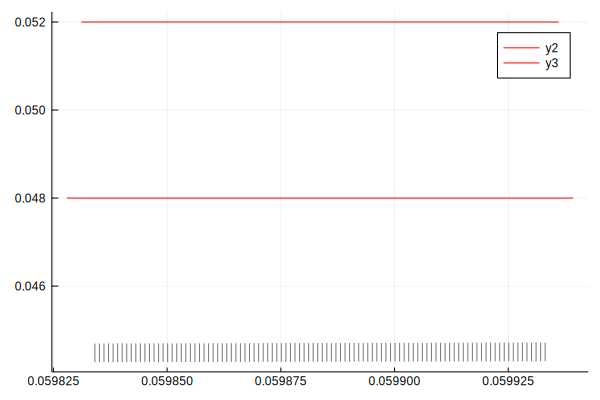

In [173]:
plot([project(X, [0, 2]) for X in sol[600][1:100:end]], vars=(0, 2))
plot!(x -> x0 + ε, color=:red)
plot!(x -> x0 - ε, color=:red)

In [172]:
tspan(sol[900])

[0.0898011, 0.0899011]

In [ ]:
x0 - maximum(sup_func(X, 2) for X in y)

In [52]:
[Interval(tspan(X)) × Interval(sup_func(X, 1), sup_func(X, 1)) for X in r1];

In [56]:
using Plots

┌ Warning: Your operating system has run out of inotify capacity.
│ Check the current value with `cat /proc/sys/fs/inotify/max_user_watches`.
│ Set it to a higher level with, e.g., `echo 65536 | sudo tee -a /proc/sys/fs/inotify/max_user_watches`.
│ This requires having administrative privileges on your machine (or talk to your sysadmin).
│ See https://github.com/timholy/Revise.jl/issues/26 for more information.
└ @ Revise /home/mforets/.julia/packages/Revise/xeiUU/src/Revise.jl:43
┌ Warning: Your operating system has run out of inotify capacity.
│ Check the current value with `cat /proc/sys/fs/inotify/max_user_watches`.
│ Set it to a higher level with, e.g., `echo 65536 | sudo tee -a /proc/sys/fs/inotify/max_user_watches`.
│ This requires having administrative privileges on your machine (or talk to your sysadmin).
│ See https://github.com/timholy/Revise.jl/issues/26 for more information.
└ @ Revise /home/mforets/.julia/packages/Revise/xeiUU/src/Revise.jl:43
┌ Warning: Your operating sy

In [57]:
plot([Interval(tspan(X)) × Singleton([sup_func(X, 1)]) for X in r1])

In [ ]:
plot!([Interval(tspan(X)) × Singleton([-sup_func(X, 2)]) for X in r1])

In [128]:
# project(sol[1], [2]) # hacer
# project(sol[1][1], (2)) # HACER

intervalo_test = Interval(x0 - ε, x0 + ε)

X = [[set(project(X, [2])) for X in sol_i] for sol_i in sol];

In [131]:
X[2][10] ⊆ intervalo_test

false

### Requirement 2

In [ ]:
# assumes that v = K/(i*drot) * I and
# I is the first (1) variable in the flowpipe
function velocity(sol, K, i, drot)
    M = hcat(K/(i*drot))
    if isa(M, Interval)
        M = IntervalMatrix(M)
    end

    V_fp = Vector{SparseReachSet}()
    for fp in sol
        for X in fp
            I_Δt = overapproximate(M * set(project(X, [1])), Zonotope)
            Δt = tspan(X)
            push!(V_fp, SparseReachSet(I_Δt, Δt, [1]))
        end
    end

    return V_fp
end

function requirement_2(sol::Vector{<:Flowpipe{N}}) where {N}

    Dx⁺ = [0, 1.0, 0, 0]
    Dx⁻ = [0, -1.0, 0, 0]
    dirs = [Dx⁺, Dx⁻]

    vtempl = Vector{TemplateReachSet{N, Vector{N}}}()
    sizehint!(vtempl, length(sol) * length(sol[1]))
    
    for fp in sol
        for X in fp
            sfunc = [ρ(Dx⁺, X), ρ(Dx⁻, X)]
            Δt = tspan(X)
            R = TemplateReachSet(dirs, sfunc, Δt)
            push!(vtempl, R)
        end
    end
    return vtempl
end